In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 25% |


In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import os
from torchmetrics import F1Score

In [4]:
random_seed = 12
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [6]:
train_dir_path = '/opt/ml/'
submission_1 = pd.read_csv(train_dir_path+'regnet.csv')
submission_2 = pd.read_csv(train_dir_path+'resnet18_multi.csv')
submission_3 = pd.read_csv(train_dir_path+'resnet50_aug.csv')
submission_4 = pd.read_csv(train_dir_path+'resnet50_best.csv')

In [23]:
from scipy.stats.mstats import mode

In [30]:
winners = mode([submission_1['ans'], submission_2['ans'], submission_3['ans'], submission_4['ans']], 0)

In [67]:
result = list(map(int, winners[0][0]))

In [68]:
for i in range(len(winners[1][0])):
    if winners[1][0][i] == 1:
        result[i] = submission_4.iloc[i]['ans']

In [88]:
for i in range(len(result)):
    if winners[1][0][i] == 2:
        if ((submission_4.iloc[i]['ans'] == submission_3.iloc[i]['ans']) and (submission_1.iloc[i]['ans'] == submission_2.iloc[i]['ans'])) or ((submission_4.iloc[i]['ans'] == submission_2.iloc[i]['ans']) and (submission_1.iloc[i]['ans'] == submission_3.iloc[i]['ans'])) or ((submission_4.iloc[i]['ans'] == submission_1.iloc[i]['ans']) and (submission_3.iloc[i]['ans'] == submission_3.iloc[i]['ans'])):
            result[i] = submission_4.iloc[i]['ans']

In [89]:
count = 0
for i in range(len(result)):
    if submission_4.iloc[i]['ans'] != result[i]:
        count += 1
count

702

In [87]:
count = 0
for i in range(len(submission_1)):
    if (submission_4.iloc[i]['ans'] != submission_3.iloc[i]['ans']) and (submission_3.iloc[i]['ans'] == submission_2.iloc[i]['ans']) and (submission_1.iloc[i]['ans'] != submission_2.iloc[i]['ans']):
        count += 1
count

336

In [51]:
print(submission_1.iloc[3481]['ans'], submission_2.iloc[3481]['ans'], submission_3.iloc[3481]['ans'], submission_4.iloc[3481]['ans'])

5 4 1 2


In [69]:
result[3481]

2

In [55]:
print(submission_1.iloc[8684]['ans'], submission_2.iloc[8684]['ans'], submission_3.iloc[8684]['ans'], submission_4.iloc[8684]['ans'])

1 0 4 2


In [70]:
result[8684]

2

In [71]:
print(submission_1.iloc[868]['ans'], submission_2.iloc[868]['ans'], submission_3.iloc[868]['ans'], submission_4.iloc[868]['ans'])

12 12 12 12


In [72]:
result[868]

12

In [90]:
test_dir_path = '/opt/ml/input/data/eval/'
submission = pd.read_csv(test_dir_path+'info.csv')
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


In [91]:
submission['ans'] = result
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12


In [92]:
submission.to_csv(os.path.join(test_dir_path, 'submission_ensemble_4.csv'), index=False)

In [93]:
output_samples = submission.sample(7)
output_samples.head()

,ImageID,ans
6713,d060efd80e5516a2cac1271a61c3f91cbb86bf98.jpg,4
5344,a76263c8f8133eac525d6ecfc6b96393a85bb458.jpg,1
9616,4adce40ba7d54808ae85045c8a7b971a6b0c9a2c.jpg,1
11401,02d815f5238114df5c75ecacdadd1b2576a3597f.jpg,0
9306,0a3a74605d24d537429a573785d1d7f26da43c7c.jpg,2


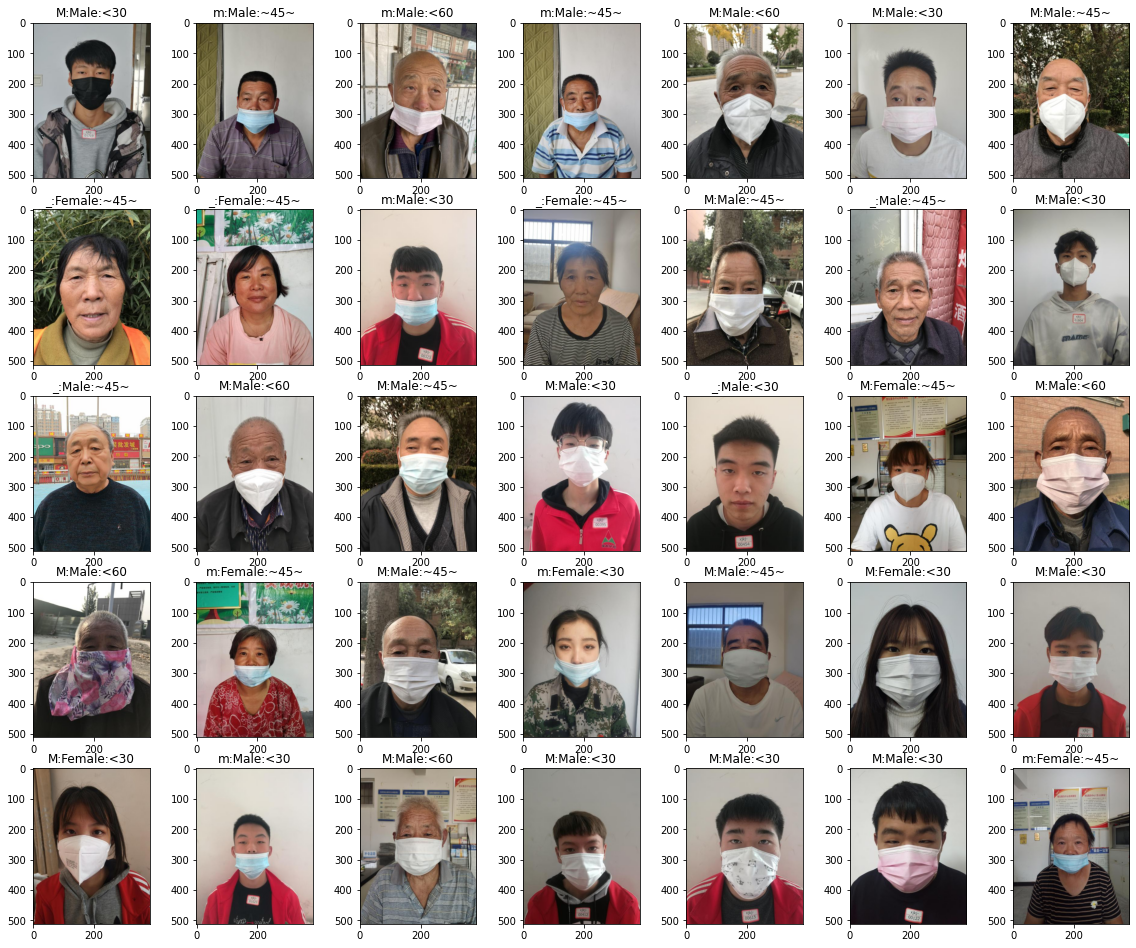

In [94]:
def show_result(df):
    classname = ['M:Male:<30','M:Male:~45~','M:Male:<60',
                 'M:Female:<30','M:Female:~45~','M:Female:<60',
                 'm:Male:<30','m:Male:~45~','m:Male:<60',
                 'm:Female:<30','m:Female:~45~','m:Female:<60',
                 '_:Male:<30','_:Male:~45~','_:Male:<60',
                 '_:Female:<30','_:Female:~45~','_:Female:<60']
    plt.figure(figsize=(20, 20))
    columns = 7
    person_len = len(df)
    for person_id in range(person_len):
        filename = "/opt/ml/input/data/eval/" + f"images/{df.iloc[person_id]['ImageID']}"
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(person_len // columns + 1, columns, person_id + 1)
        plt.imshow(img)
        plt.gca().set_title(classname[df.iloc[person_id]['ans']])

output_samples = submission.sample(5 * 7)
show_result(output_samples)

In [85]:
count = 0
for i in range(len(submission['ans'])):
    if (submission_1.iloc[i]['ans'] == submission_2.iloc[i]['ans']) and (submission_3.iloc[i]['ans'] == submission_2.iloc[i]['ans']) and (submission_3.iloc[i]['ans'] == submission_4.iloc[i]['ans']):
        count += 1
count

9359

In [95]:
count = 0 
for i in range(len(submission['ans'])):
    if submission_4.iloc[i]['ans'] != submission.iloc[i]['ans']:
        count += 1
count

702